# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Thu Apr 13 21:48:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   43C    P8    21W / 350W |  21052MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download and import required packages

In [2]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [3]:
seed = 33
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* TED2020
    - Raw: 400,726 (sentences)   
    - Processed: 394,052 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [4]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.data.tgz",
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ml2023.hw5.test.tgz"
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## Language

In [5]:
# src_lang = 'en'
# tgt_lang = 'zh'
src_lang = 'zh'
tgt_lang = 'en'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [6]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because I need that.
Put yourselves in my position.


## Preprocess files

In [7]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation, r'\1'向右一格
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [8]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/train_dev.raw.clean.zh & en exists. skipping clean.
/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/test.raw.clean.zh & en exists. skipping clean.


In [9]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


## Split into train/valid

In [10]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [11]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num)) # [0, 1, ... , len(line_num)]
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [12]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [13]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.


In [14]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!
▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁tr u ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.


## Binarize the data with fairseq
Prepare the files in pairs for both the source and target languages. \\
In case a pair is unavailable, generate a pseudo pair to facilitate binarization.

In [15]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [16]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    # savedir = "./checkpoints/rnn",
    savedir = "./checkpoints/transformer",
    source_lang = src_lang,
    target_lang = tgt_lang,
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [17]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [18]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2023-04-13 21:48:24 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2023-04-13 21:48:24 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.700 GB ; name = NVIDIA GeForce RTX 3090                 
2023-04-13 21:48:24 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [19]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-04-13 21:48:24 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types
2023-04-13 21:48:24 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types


In [20]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-04-13 21:48:24 | INFO | hw5.seq2seq | loading data for epoch 1
2023-04-13 21:48:24 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.zh-en.zh
2023-04-13 21:48:24 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.zh-en.en
2023-04-13 21:48:24 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390112 examples
2023-04-13 21:48:24 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.zh-en.zh
2023-04-13 21:48:24 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.zh-en.en
2023-04-13 21:48:24 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3940 examples


In [21]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 162,  116, 3756,  364,  158, 3055, 2925,    9, 2547,    4,  596,  123,
        1518,  455,  667,   64,  406,  566,   74, 1908, 3790,  191,   10,    2]),
 'target': tensor([  24,   63,    5,   90, 1323,  143,  140,  184,  281,   37,    8,   81,
         254,   11,   80,   55,   12,  376,   20,  155,   60, 1007,   98,  587,
          76,  256,    6,   98, 1465,    7,    2])}
'Source: 你能拋開這些瘋狂的理論 , 不用數據圖表、或研究來支撐它 。'
('Target: you can throw out crazy theories and not have to back it up with '
 'data or graphs or research .')


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [22]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2023-04-13 21:48:24 | WARNING | fairseq.tasks.fairseq_task | 2,494 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[216, 3082, 2712, 2721, 3811, 2573, 631, 3246, 3109, 1342]


{'id': tensor([2427]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    5, 3782, 6333,   66, 3833, 1334,  152,  606,   69, 1063,
           1526,  230,   10,    2]]),
  'src_lengths': tensor([14]),
  'prev_output_tokens': tensor([[   2,  140,  251, 1640,   11, 1458,  333,  178,   51,  540,  411,   72,
            444,  122,   15,   12, 2118,    7,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  251, 1640,   11, 1458,  333,  178,   51,  540,  411,   72,  444,
           122,   15,   12, 2118,    7,    2,    1,    1,    1,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [23]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [24]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [25]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [26]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    # encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [27]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024, # 512 -> 1024
    encoder_layers=4, # 1 -> 4
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4, # 1 -> 4
    share_decoder_input_output_embed=True,
    dropout=0.15, # 0.3 -> 0.15
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [28]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [29]:
model = build_model(arch_args, task)
logger.info(model)

2023-04-13 21:48:25 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [30]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [31]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    # lr = 0.001
    lr = (d_model**(-0.5) * min(step_num**(-0.5), step_num*(warmup_step**(-1.5))))
    
    return lr

In [32]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

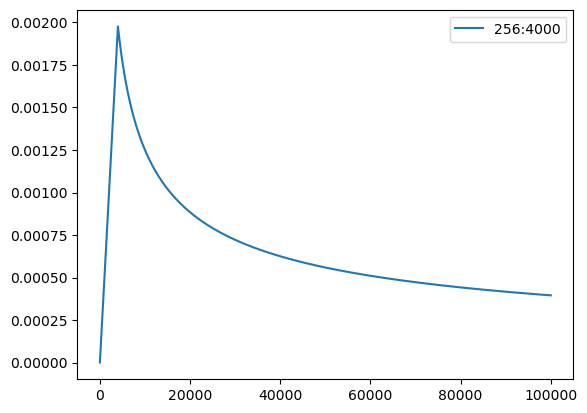

In [33]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [34]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [35]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [36]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [37]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [38]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [39]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2023-04-13 21:48:27 | INFO | hw5.seq2seq | task: TranslationTask
2023-04-13 21:48:27 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2023-04-13 21:48:27 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2023-04-13 21:48:27 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2023-04-13 21:48:27 | INFO | hw5.seq2seq | optimizer: NoamOpt
2023-04-13 21:48:27 | INFO | hw5.seq2seq | num. model params: 11,465,728 (num. trained: 11,465,728)
2023-04-13 21:48:27 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [40]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-04-13 15:23:20 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326653]
2023-04-13 15:23:20 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer/checkpoint_last.pt: step=24420 loss=2.7162656784057617 bleu=19.556441368398907


train epoch 1:   0%|          | 0/799 [00:00<?, ?it/s]

2023-04-13 15:24:27 | INFO | hw5.seq2seq | training loss: 2.6039
2023-04-13 15:24:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2023-04-13 15:24:35 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2023-04-13 15:24:35 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2023-04-13 15:24:35 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2023-04-13 15:24:35 | INFO | hw5.seq2seq | example source: 在當局切斷網路和電信通訊的幾個小時前 , 我於午夜時分走在開羅一個陰暗的街道上 ,
2023-04-13 15:24:35 | INFO | hw5.seq2seq | example hypothesis: just a few hours before the authorities cut off the internet and the telecommunications , i was separated from a dark street in cairo at night .
2023-04-13 15:24:35 | INFO | hw5.seq2seq | example reference: a few hours before the regime cut off the internet and telecommunications , i was walking in a dark street in cairo , around midnight .
2023-04-13 15:24:35 | INFO | hw5.seq2seq | validation loss:	2.7266
2023-04-13 15:24:35 | INFO | hw5.seq2seq | BL

train epoch 2:   0%|          | 0/799 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Submission

In [42]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

python: can't open file '/home/darkqq/LAB/robert/ML/TEST/./fairseq/scripts/average_checkpoints.py': [Errno 2] No such file or directory


## Confirm model weights used to generate submission

In [43]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt: the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-04-13 15:42:47 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer/avg_last_5_checkpoint.pt!
2023-04-13 15:42:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2023-04-13 15:42:57 | INFO | hw5.seq2seq | example source: 在當局切斷網路和電信通訊的幾個小時前 , 我於午夜時分走在開羅一個陰暗的街道上 ,
2023-04-13 15:42:57 | INFO | hw5.seq2seq | example hypothesis: 潺潺潺潺潺潺潺潺潺潺 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是 而是
2023-04-13 15:42:57 | INFO | hw5.seq2seq | example reference: a few hours before the regime cut off the internet and telecommunications , i was walking in a dark street in cairo , around midnight .
2023-04-13 15:42:57 | INFO | hw5.seq2seq | validation loss:	9.0545
2023-04-13 15:42:57 | INFO | hw5.seq2seq | BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.794 hyp_len = 136345 ref_len = 76016)


## Generate Prediction

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [ ]:
generate_prediction(model, task)

2023-04-12 22:28:43 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.zh-en.zh
2023-04-12 22:28:43 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.zh-en.en
2023-04-12 22:28:43 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test zh-en 4000 examples


prediction:   0%|          | 0/18 [00:00<?, ?it/s]

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [40]:
data_dir = './DATA/rawdata'
mono_dataset_name = 'mono'
save_dir = "./checkpoints/transformer-back"

In [41]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/figisiwirf/ml2023-hw5-dataset/releases/download/v1.0.1/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


In [42]:
mono_test = "./DATA/rawdata/mono/ted_zh_corpus.deduped"
!head {mono_test} -n 5

在 16 世紀中葉 意大利人被一種男歌手迷住了 那種男歌手的音域廣闊，包含的音高 先前是一般成年男性不可能達到的
但是，這天賦有一個很高的代價
要防止他們變聲 這些歌手在青春期前被閹割 來停止荷爾蒙的變化， 以免他們的聲線變低沉
被稱為「閹伶」，他們輕輕的、 天使般的聲音在整個歐洲很有名 直到這個殘酷的程序， 在 19 世紀被禁止
雖然阻止聲帶的成長， 可以產生一個非凡廣闊的音域 但自然發展的聲音， 已經具有極多的可能性


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [43]:
print(mono_prefix)

/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/mono


In [44]:
print(src_lang)

zh


In [45]:
def clean_corpus_mono(mono_prefix, l1, ratio=9, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/clean.{l1}').exists():
        print(f'{mono_prefix}.clean.{l1} exists. skipping clean. ')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/clean.{l1}', 'w') as l1_out_f:
            for s1 in l1_in_f:
                s1 = s1.strip()
                s1 = clean_s(s1, l1) # l1 = zh
                s1_len = len_s(s1, l1)
                if min_len > 0: # remove short sentence
                    if s1_len < min_len:
                        continue
                if max_len > 0: # remove long sentence
                    if s1_len > max_len:
                        continue
                print(s1, file=l1_out_f)

In [46]:
clean_corpus_mono(mono_prefix, src_lang)

/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/mono.clean.zh exists. skipping clean. 


In [47]:
!head {f'{mono_prefix}/clean.{src_lang}'} -n 5

head: cannot open '{f{mono_prefix}/clean.{src_lang}}' for reading: No such file or directory


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [48]:
print(mono_prefix)
print(mono_test)

/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/mono
./DATA/rawdata/mono/ted_zh_corpus.deduped


In [49]:
import sentencepiece as spm
vocab_size = 8000
spm_model_mono = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))

with open(mono_prefix/f'mono.tok.{src_lang}', 'w') as out_f:
    with open(mono_prefix/f'clean.{src_lang}', 'r') as in_f:
        with open(mono_prefix/f'mono.tok.en', 'w') as en:
            for line in in_f:
                line = line.strip()
                tok = spm_model_mono.encode(line, out_type=str)
                print(' '.join(tok), file=out_f)
                print(".", file=en)

In [50]:
!head {'/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/mono/mono.tok.zh'} -n 5
!head {'/home/darkqq/LAB/robert/ML/TEST/DATA/rawdata/mono/mono.tok.en'} -n 5

▁在 16 世紀 中 葉 意 大 利 人 被 一種 男 歌 手 迷 住 了 那種 男 歌 手 的 音 域 廣 闊 ▁, ▁ 包 含 的 音 高 先 前 是 一般 成 年 男性 不可能 達到 的
▁但是 ▁, ▁這 天 賦 有一個 很 高 的 代 價
▁要 防 止 他們 變 聲 這些 歌 手 在 青 春 期 前 被 閹 割 來 停 止 荷 爾 蒙 的 變化 ▁, ▁以 免 他們的 聲 線 變 低 沉
▁ 被 稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的 聲音 在 整個 歐 洲 很 有 名 直 到 這個 殘 酷 的 程 序 ▁, ▁在 19 世紀 被 禁 止
▁雖然 阻 止 聲 帶 的 成長 ▁, ▁ 可以 產生 一個 非 凡 廣 闊 的 音 域 但 自然 發展 的 聲音 ▁, ▁ 已經 具 有 極 多 的 可能 性
.
.
.
.
.


### Binarize

use fairseq to binarize data

In [51]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [52]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [53]:
def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

In [54]:
src_lang = 'zh'
tgt_lang = 'en'
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    # savedir = "./checkpoints/rnn",
    savedir = "./checkpoints/transformer",
    source_lang = src_lang,
    target_lang = tgt_lang,
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2,
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [55]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )
def generate_prediction_mono(model, task, split="mono", outfile="./prediction_mono.txt"):
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [57]:
generate_prediction_mono(model, task)

2023-04-13 21:51:03 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2023-04-13 21:51:03 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2023-04-13 21:51:03 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


prediction:   0%|          | 0/1716 [00:00<?, ?it/s]

KeyboardInterrupt: 

### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [58]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
mono_rawdata = "./prediction_mono.txt"
# hint: tokenize prediction_file with the spm model
# "ted_zh_corpus.deduped.clean_sub.zh" : tokenize mono.zh with the spm model
mono_en_tokfile = Path('./DATA/rawdata/mono/mono.tok.en')
!cp ./DATA/rawdata/mono/ted_zh_corpus.deduped.clean_sub.zh ./DATA/rawdata/mono/mono.tok.zh
mono_zh_tokfile = Path('./DATA/rawdata/mono/mono.tok.zh')
if mono_en_tokfile.exists():
    print(f"{mono_en_tokfile} exists. skipping spm_encode.")
else:
    with open(mono_en_tokfile, 'w') as out_f:
        with open('./prediction_mono.txt', 'r') as in_f:
            for line in in_f:
                tok = spm_model.encode(line, out_type=str)
                print(' '.join(tok), file=out_f)
!head {mono_en_tokfile} -n 5
!head {mono_zh_tokfile} -n 5
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh

# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = './DATA/rawdata/mono/mono.tok'
# or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\ 
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

cp: cannot stat './DATA/rawdata/mono/ted_zh_corpus.deduped.clean_sub.zh': No such file or directory
DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.
.
.
.
.
.
▁在 16 世紀 中 葉 意 大 利 人 被 一種 男 歌 手 迷 住 了 那種 男 歌 手 的 音 域 廣 闊 ▁, ▁ 包 含 的 音 高 先 前 是 一般 成 年 男性 不可能 達到 的
▁但是 ▁, ▁這 天 賦 有一個 很 高 的 代 價
▁要 防 止 他們 變 聲 這些 歌 手 在 青 春 期 前 被 閹 割 來 停 止 荷 爾 蒙 的 變化 ▁, ▁以 免 他們的 聲 線 變 低 沉
▁ 被 稱為 ▁「 ▁ 閹 伶 ▁」 ▁, ▁他們 輕 輕 的 、 天 使 般 的 聲音 在 整個 歐 洲 很 有 名 直 到 這個 殘 酷 的 程 序 ▁, ▁在 19 世紀 被 禁 止
▁雖然 阻 止 聲 帶 的 成長 ▁, ▁ 可以 產生 一個 非 凡 廣 闊 的 音 域 但 自然 發展 的 聲音 ▁, ▁ 已經 具 有 極 多 的 可能 性
DATA/data-bin/synthetic exists, will not overwrite!


In [59]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

In [75]:
src_lang = 'en'
tgt_lang = 'zh'

config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    # savedir = "./checkpoints/rnn",
    savedir = "./checkpoints/transformer-bt",
    source_lang = src_lang,
    target_lang = tgt_lang,
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=90,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2,
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [61]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-04-13 21:51:16 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2023-04-13 21:51:16 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [62]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-04-13 21:51:16 | INFO | hw5.seq2seq | loading data for epoch 1
2023-04-13 21:51:16 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020_with_mono/train.zh-en.en
2023-04-13 21:51:16 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020_with_mono/train.zh-en.zh
2023-04-13 21:51:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390112 examples
2023-04-13 21:51:16 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2023-04-13 21:51:16 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2023-04-13 21:51:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2023-04-13 21:51:16 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020_with_mono/valid.zh-en.en
2023-04-13 21:51:16 | I

In [76]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2023-04-14 01:08:09 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-bt/checkpoint_last.pt: step=79361 loss=3.3347928524017334 bleu=26.346512287769006


train epoch 31:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:10:38 | INFO | hw5.seq2seq | training loss: 2.9937
2023-04-14 01:10:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:10:47 | INFO | hw5.seq2seq | example source: ynh: yes , very much so .
2023-04-14 01:10:47 | INFO | hw5.seq2seq | example hypothesis: 尤:是的 , 非常多 。
2023-04-14 01:10:47 | INFO | hw5.seq2seq | example reference: 尤:是的 , 就是這樣 。
2023-04-14 01:10:47 | INFO | hw5.seq2seq | validation loss:	3.3398
2023-04-14 01:10:47 | INFO | hw5.seq2seq | BLEU = 26.39 58.8/33.9/20.5/13.1 (BP = 0.975 ratio = 0.976 hyp_len = 107754 ref_len = 110430)
2023-04-14 01:10:47 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint31.pt
2023-04-14 01:10:47 | INFO | hw5.seq2seq | end of epoch 31


train epoch 32:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:13:17 | INFO | hw5.seq2seq | training loss: 2.9915
2023-04-14 01:13:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:13:26 | INFO | hw5.seq2seq | example source: i carefully placed my hand into the clam's mouth and waited .
2023-04-14 01:13:26 | INFO | hw5.seq2seq | example hypothesis: 我小心地把手放到蚌嘴裡 , 等待 。
2023-04-14 01:13:26 | INFO | hw5.seq2seq | example reference: 我小心地把我的手放到蚌蛤的口中 , 等待著 。
2023-04-14 01:13:26 | INFO | hw5.seq2seq | validation loss:	3.3253
2023-04-14 01:13:26 | INFO | hw5.seq2seq | BLEU = 26.33 58.6/33.6/20.3/12.9 (BP = 0.982 ratio = 0.982 hyp_len = 108483 ref_len = 110430)
2023-04-14 01:13:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint32.pt
2023-04-14 01:13:26 | INFO | hw5.seq2seq | end of epoch 32


train epoch 33:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:15:57 | INFO | hw5.seq2seq | training loss: 2.9870
2023-04-14 01:15:57 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:16:05 | INFO | hw5.seq2seq | example source: and then what happens when you think about this trajectory for the future ?
2023-04-14 01:16:05 | INFO | hw5.seq2seq | example hypothesis: 然後當你想到這個對未來的軌跡 , 會發生什麼事 ?
2023-04-14 01:16:05 | INFO | hw5.seq2seq | example reference: 想想看 , 若根據這樣的軌道 , 未來會是怎樣的 ?
2023-04-14 01:16:05 | INFO | hw5.seq2seq | validation loss:	3.3232
2023-04-14 01:16:05 | INFO | hw5.seq2seq | BLEU = 26.21 59.2/34.2/20.7/13.3 (BP = 0.959 ratio = 0.960 hyp_len = 106039 ref_len = 110430)
2023-04-14 01:16:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint33.pt
2023-04-14 01:16:05 | INFO | hw5.seq2seq | end of epoch 33


train epoch 34:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:18:36 | INFO | hw5.seq2seq | training loss: 2.9836
2023-04-14 01:18:36 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:18:44 | INFO | hw5.seq2seq | example source: it protects our planet from too many impacts , from meteorites and the like .
2023-04-14 01:18:44 | INFO | hw5.seq2seq | example hypothesis: 它保護我們的星球不受太多影響 , 不受隕石和類似的影響 。
2023-04-14 01:18:44 | INFO | hw5.seq2seq | example reference: 大氣保護地球 , 免受太多侵害 , 例如隕石墜落 。
2023-04-14 01:18:44 | INFO | hw5.seq2seq | validation loss:	3.3232
2023-04-14 01:18:44 | INFO | hw5.seq2seq | BLEU = 26.39 59.2/34.1/20.7/13.3 (BP = 0.966 ratio = 0.967 hyp_len = 106778 ref_len = 110430)
2023-04-14 01:18:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint34.pt
2023-04-14 01:18:44 | INFO | hw5.seq2seq | end of epoch 34


train epoch 35:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:21:15 | INFO | hw5.seq2seq | training loss: 2.9809
2023-04-14 01:21:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:21:24 | INFO | hw5.seq2seq | example source: so , a team of berkeley researchers with 15 million dollars from the gates foundation is engineering , designing a radical new way to make the key ingredient , called artemisinin , and they're going to make that drug 10 times cheaper .
2023-04-14 01:21:24 | INFO | hw5.seq2seq | example hypothesis: 所以 , 柏克萊研究團隊有一億五千萬美元來自蓋茲基金會的團隊正在工程 , 設計出一種激進的新方法 , 來製造關鍵成分 , 叫做 「 亞瑟芬 」 , 他們會讓那藥物更便宜十倍 。
2023-04-14 01:21:24 | INFO | hw5.seq2seq | example reference: 柏克萊的團隊得到gatesfoundation的1千5百萬的經費 , 以研發設計一顛覆式的新方法來製造一個叫 " 青蒿素 " 的關鍵成分希望能製造出10倍便宜的藥物
2023-04-14 01:21:24 | INFO | hw5.seq2seq | validation loss:	3.3179
2023-04-14 01:21:24 | INFO | hw5.seq2seq | BLEU = 26.63 58.8/33.9/20.5/13.1 (BP = 0.984 ratio = 0.984 hyp_len = 108694 ref_len = 110430)
2023-04-14 01:21:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint35.pt
2023-04-14 01:21:24 | INFO | hw5.seq2seq | end of epoch 35


train epoch 36:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:23:53 | INFO | hw5.seq2seq | training loss: 2.9779
2023-04-14 01:23:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:24:02 | INFO | hw5.seq2seq | example source: while they're mating , the male is busy giving the female not just his sperm but also a nutrientfilled package called a nuptial gift .
2023-04-14 01:24:02 | INFO | hw5.seq2seq | example hypothesis: 當牠們在交配時 , 雄蟲正忙著給雌蟲不僅僅僅是牠的精子 , 還有一個營養填滿的包裝 , 叫做 「 尼事禮物 」 。
2023-04-14 01:24:02 | INFO | hw5.seq2seq | example reference: 當它們交配時 , 雄螢火蟲不止忙著向雌螢火蟲射精 , 還給她一個富含營養的袋子 , 叫做新婚彩禮 。
2023-04-14 01:24:02 | INFO | hw5.seq2seq | validation loss:	3.3171
2023-04-14 01:24:02 | INFO | hw5.seq2seq | BLEU = 26.74 58.3/33.5/20.4/13.0 (BP = 0.996 ratio = 0.996 hyp_len = 109955 ref_len = 110430)
2023-04-14 01:24:02 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint36.pt
2023-04-14 01:24:02 | INFO | hw5.seq2seq | end of epoch 36


train epoch 37:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:26:31 | INFO | hw5.seq2seq | training loss: 2.9764
2023-04-14 01:26:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:26:40 | INFO | hw5.seq2seq | example source: the second tool we reach for is incentives .
2023-04-14 01:26:40 | INFO | hw5.seq2seq | example hypothesis: 我們接觸到的第二個工具是激勵機制 。
2023-04-14 01:26:40 | INFO | hw5.seq2seq | example reference: 第二種工具就是我們會尋求激勵的制度 。
2023-04-14 01:26:40 | INFO | hw5.seq2seq | validation loss:	3.3261
2023-04-14 01:26:40 | INFO | hw5.seq2seq | BLEU = 26.71 58.4/33.6/20.4/13.0 (BP = 0.995 ratio = 0.995 hyp_len = 109900 ref_len = 110430)
2023-04-14 01:26:40 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint37.pt
2023-04-14 01:26:40 | INFO | hw5.seq2seq | end of epoch 37


train epoch 38:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:29:10 | INFO | hw5.seq2seq | training loss: 2.9737
2023-04-14 01:29:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:29:19 | INFO | hw5.seq2seq | example source: but they were random things .
2023-04-14 01:29:19 | INFO | hw5.seq2seq | example hypothesis: 但他們是隨機的東西 。
2023-04-14 01:29:19 | INFO | hw5.seq2seq | example reference: 完全出乎我的意料之外 。
2023-04-14 01:29:19 | INFO | hw5.seq2seq | validation loss:	3.3143
2023-04-14 01:29:19 | INFO | hw5.seq2seq | BLEU = 26.55 58.9/33.9/20.6/13.2 (BP = 0.977 ratio = 0.977 hyp_len = 107913 ref_len = 110430)
2023-04-14 01:29:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint38.pt
2023-04-14 01:29:19 | INFO | hw5.seq2seq | end of epoch 38


train epoch 39:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:31:49 | INFO | hw5.seq2seq | training loss: 2.9702
2023-04-14 01:31:49 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:31:58 | INFO | hw5.seq2seq | example source: online misogyny is a global gender rights tragedy , and it is imperative that it ends .
2023-04-14 01:31:58 | INFO | hw5.seq2seq | example hypothesis: 線上陰蒂是全球性別權利的悲劇 , 它的結局是不可或缺的 。
2023-04-14 01:31:58 | INFO | hw5.seq2seq | example reference: 網路仇女現象 , 是全球性別平權運動的災難 , 我們必須終結這個亂象 。
2023-04-14 01:31:58 | INFO | hw5.seq2seq | validation loss:	3.3171
2023-04-14 01:31:58 | INFO | hw5.seq2seq | BLEU = 26.59 58.5/33.7/20.4/13.1 (BP = 0.987 ratio = 0.987 hyp_len = 108960 ref_len = 110430)
2023-04-14 01:31:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint39.pt
2023-04-14 01:31:58 | INFO | hw5.seq2seq | end of epoch 39


train epoch 40:   0%|          | 0/1869 [00:00<?, ?it/s]

2023-04-14 01:34:29 | INFO | hw5.seq2seq | training loss: 2.9669
2023-04-14 01:34:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:34:37 | INFO | hw5.seq2seq | example source: it said yorktown on the stern .
2023-04-14 01:34:37 | INFO | hw5.seq2seq | example hypothesis: 它在刻板上說了紐約 。
2023-04-14 01:34:37 | INFO | hw5.seq2seq | example reference: 在船舷上寫著〔約克鎮號〕
2023-04-14 01:34:37 | INFO | hw5.seq2seq | validation loss:	3.3042
2023-04-14 01:34:37 | INFO | hw5.seq2seq | BLEU = 26.52 58.9/33.9/20.6/13.2 (BP = 0.977 ratio = 0.977 hyp_len = 107896 ref_len = 110430)
2023-04-14 01:34:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/darkqq/LAB/robert/ML/TEST/checkpoints/transformer-bt/checkpoint40.pt
2023-04-14 01:34:37 | INFO | hw5.seq2seq | end of epoch 40


train epoch 41:   0%|          | 0/1869 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [69]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(inputs=['./checkpoints/transformer-bt'], output='./checkpoints/transformer-bt/avg_last_5_checkpoint.pt', num_epoch_checkpoints=5, num_update_checkpoints=None, checkpoint_upper_bound=None)
averaging checkpoints:  ['./checkpoints/transformer-bt/checkpoint30.pt', './checkpoints/transformer-bt/checkpoint29.pt', './checkpoints/transformer-bt/checkpoint28.pt', './checkpoints/transformer-bt/checkpoint27.pt', './checkpoints/transformer-bt/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer-bt/avg_last_5_checkpoint.pt


In [70]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt: the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2023-04-14 01:04:23 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-bt/avg_last_5_checkpoint.pt: step=unknown loss=3.3347928524017334 bleu=26.346512287769006
2023-04-14 01:04:23 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2023-04-14 01:04:32 | INFO | hw5.seq2seq | example source: we've also talked about concentrations of carbon dioxide in the atmosphere .
2023-04-14 01:04:32 | INFO | hw5.seq2seq | example hypothesis: 我們也談過大氣中的二氧化碳濃度 。
2023-04-14 01:04:32 | INFO | hw5.seq2seq | example reference: 我們還討論了大氣層中二氧化碳的濃度 。
2023-04-14 01:04:32 | INFO | hw5.seq2seq | validation loss:	3.3279
2023-04-14 01:04:32 | INFO | hw5.seq2seq | BLEU = 26.57 58.6/33.7/20.4/13.1 (BP = 0.985 ratio = 0.986 hyp_len = 108831 ref_len = 110430)


In [67]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [71]:
generate_prediction(model, task)

2023-04-14 01:04:37 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.zh-en.en
2023-04-14 01:04:37 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.zh-en.zh
2023-04-14 01:04:37 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction:   0%|          | 0/18 [00:00<?, ?it/s]